In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
import pymc.sampling_jax
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
kidiq = pd.read_stata("../data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

In [6]:
mod = bmb.Model("kid_score ~ mom_hs", kidiq)

In [7]:
results = mod.fit(method="nuts_numpyro", idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:01.324735
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.696625
Transforming variables...
Transformation time =  0:00:00.015966
Computing Log Likelihood...


Log Likelihood time =  0:00:00.242390


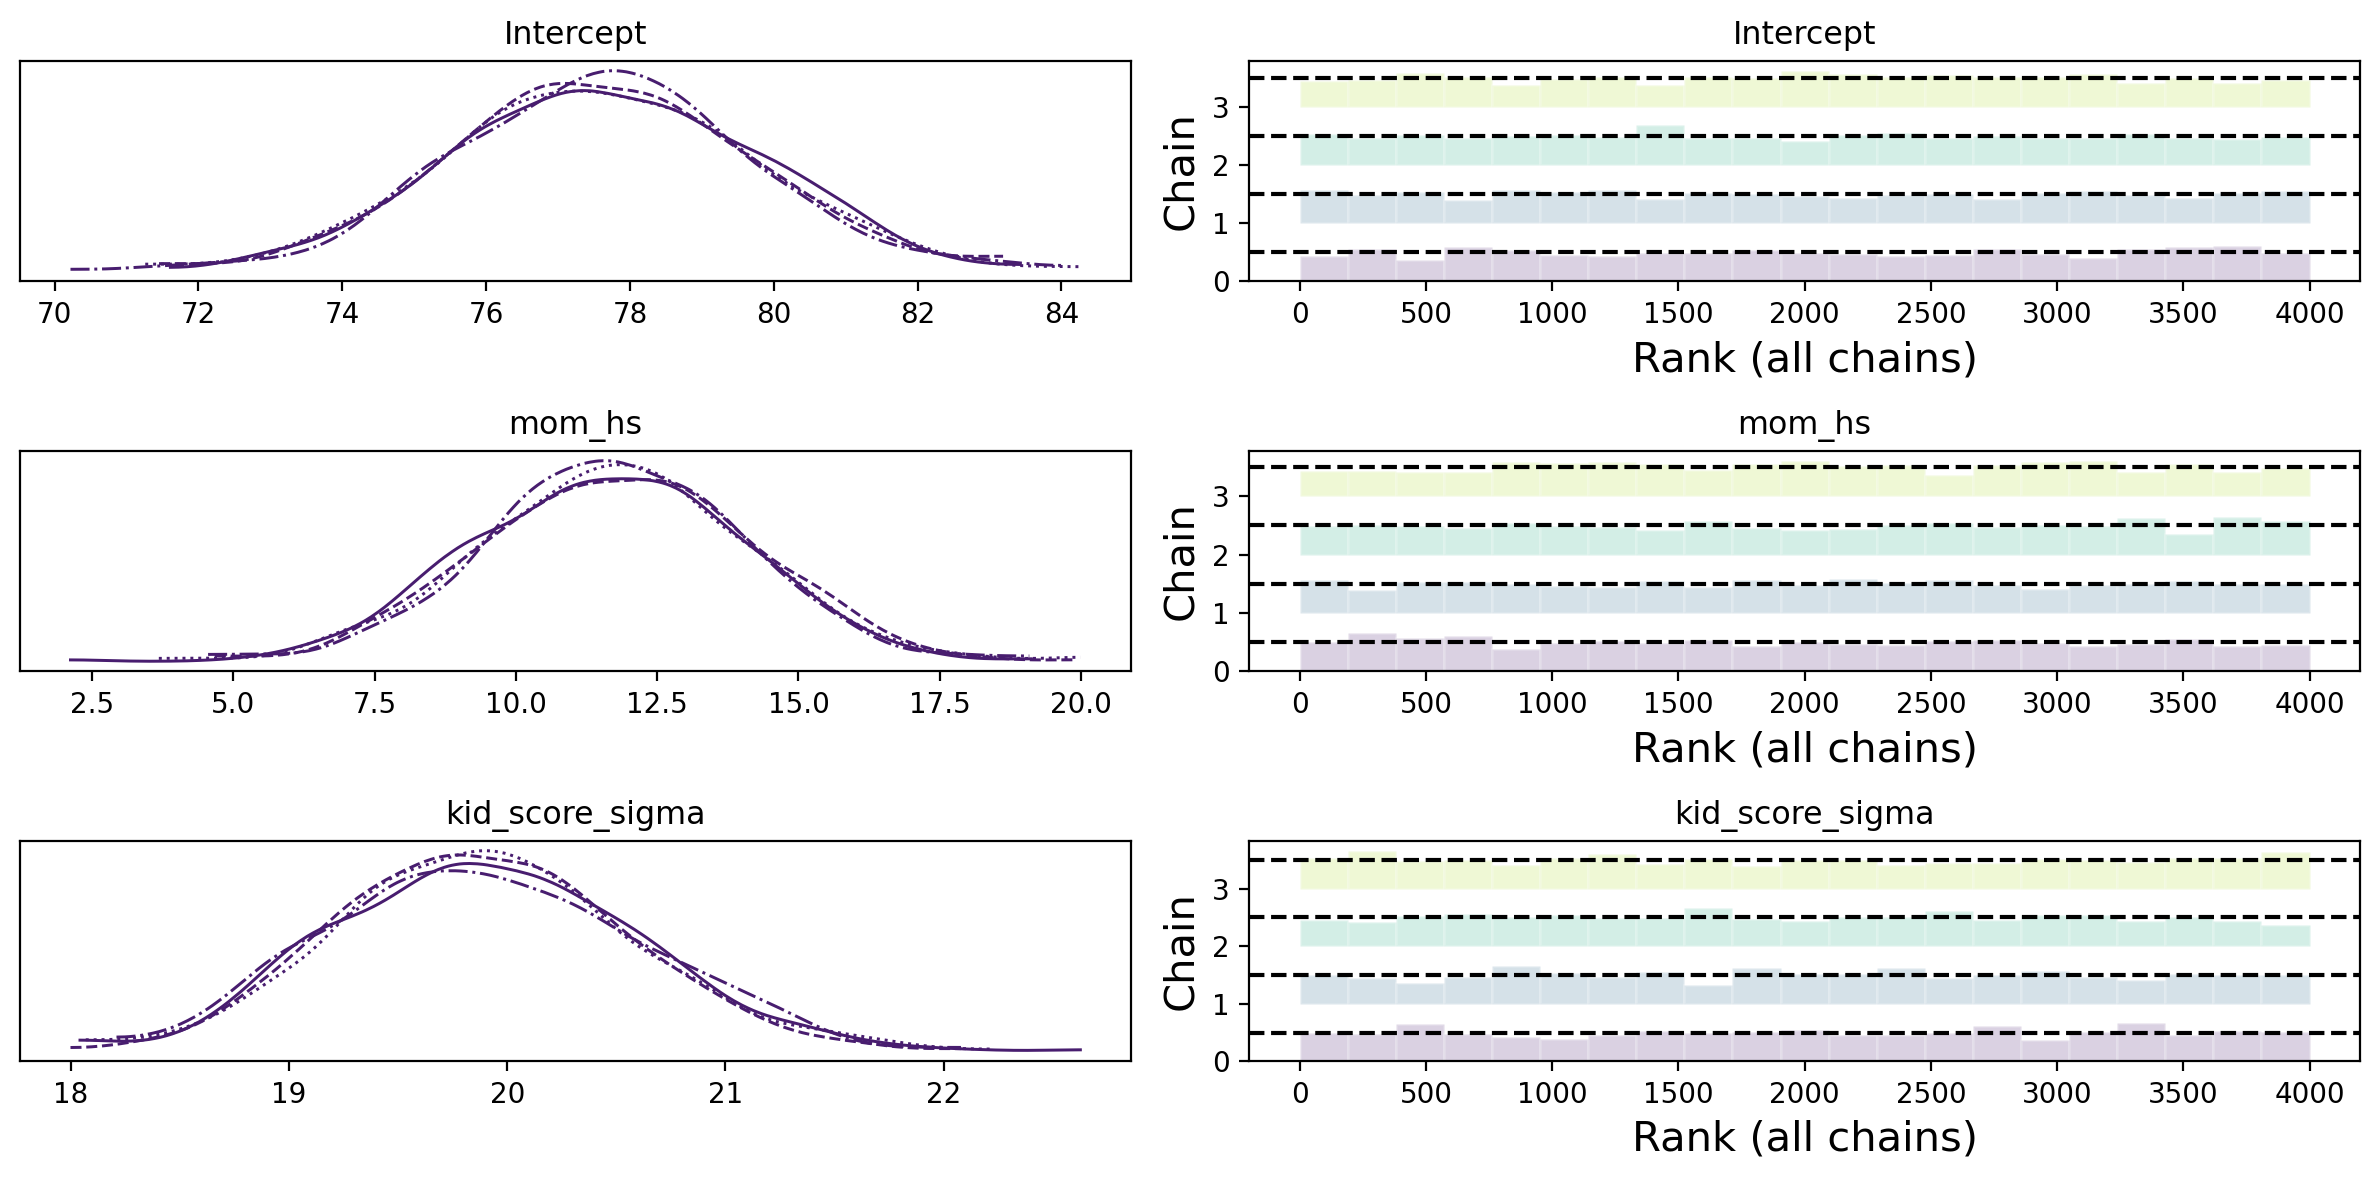

In [8]:
az.plot_trace(results, kind="rank_bars")
plt.tight_layout();

In [9]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,77.61,2.09,74.00,81.80,0.03,0.02,4481.90,3076.72,1.0
mom_hs,11.73,2.33,7.27,15.91,0.04,0.02,4383.39,3459.71,1.0
kid_score_sigma,19.90,0.68,18.69,21.21,0.01,0.01,4717.51,3402.38,1.0


In [10]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 3

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])

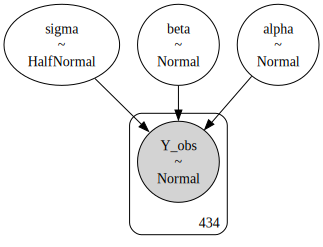

In [11]:
pm.model_to_graphviz(model)

In [12]:
with model:
    prior_samples = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


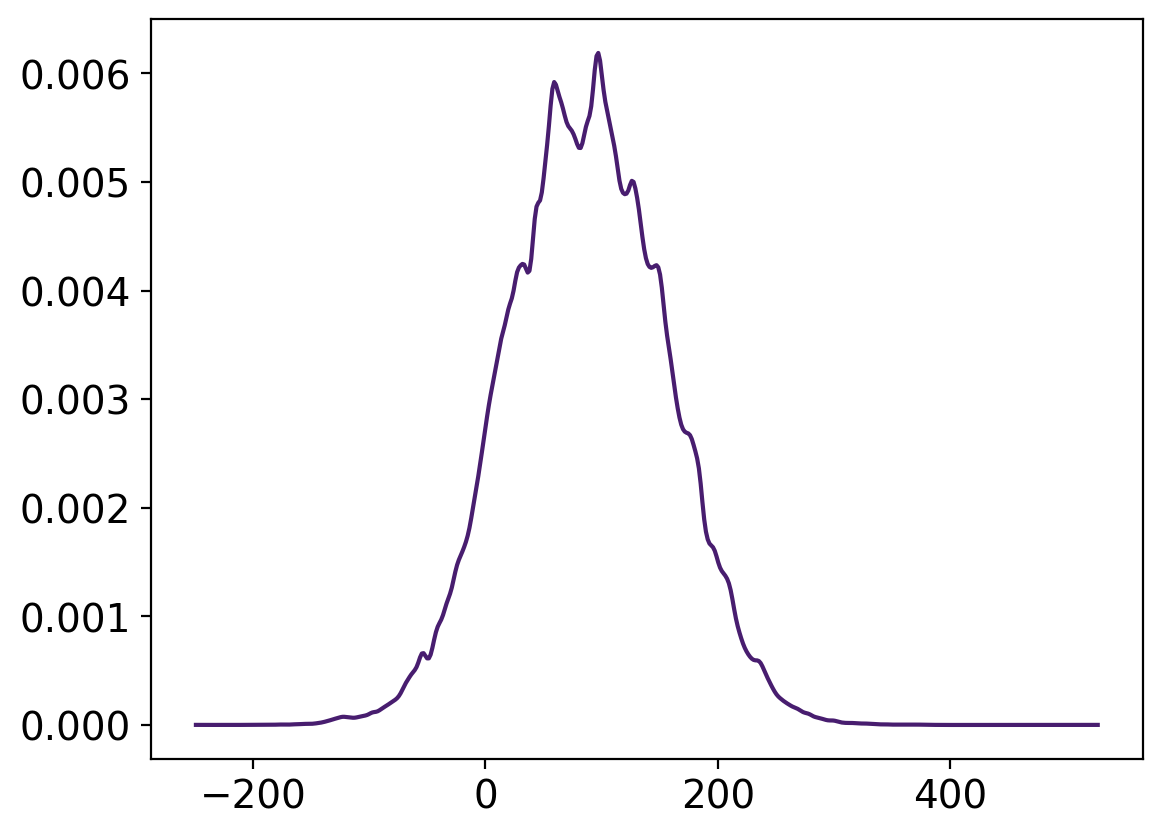

In [13]:
az.plot_dist(prior_samples.prior_predictive["Y_obs"]);

In [14]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.445289
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.538517
Transforming variables...
Transformation time =  0:00:00.005085


In [15]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.07,2.04,74.29,81.85,0.05,0.04,1441.66,1805.61,1.01
beta,11.12,2.28,6.66,15.12,0.06,0.04,1427.25,1599.06,1.00
sigma,19.91,0.68,18.63,21.19,0.01,0.01,2261.23,1850.28,1.00


In [16]:
with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=30)
    # Expected value of outcome
    mu = alpha + beta * kidiq["mom_hs"] 
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kidiq["kid_score"])
    
    effect_size = pm.Deterministic("effect size", beta / sigma)
    
    trace = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.504576
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.526227
Transforming variables...
Transformation time =  0:00:00.019415


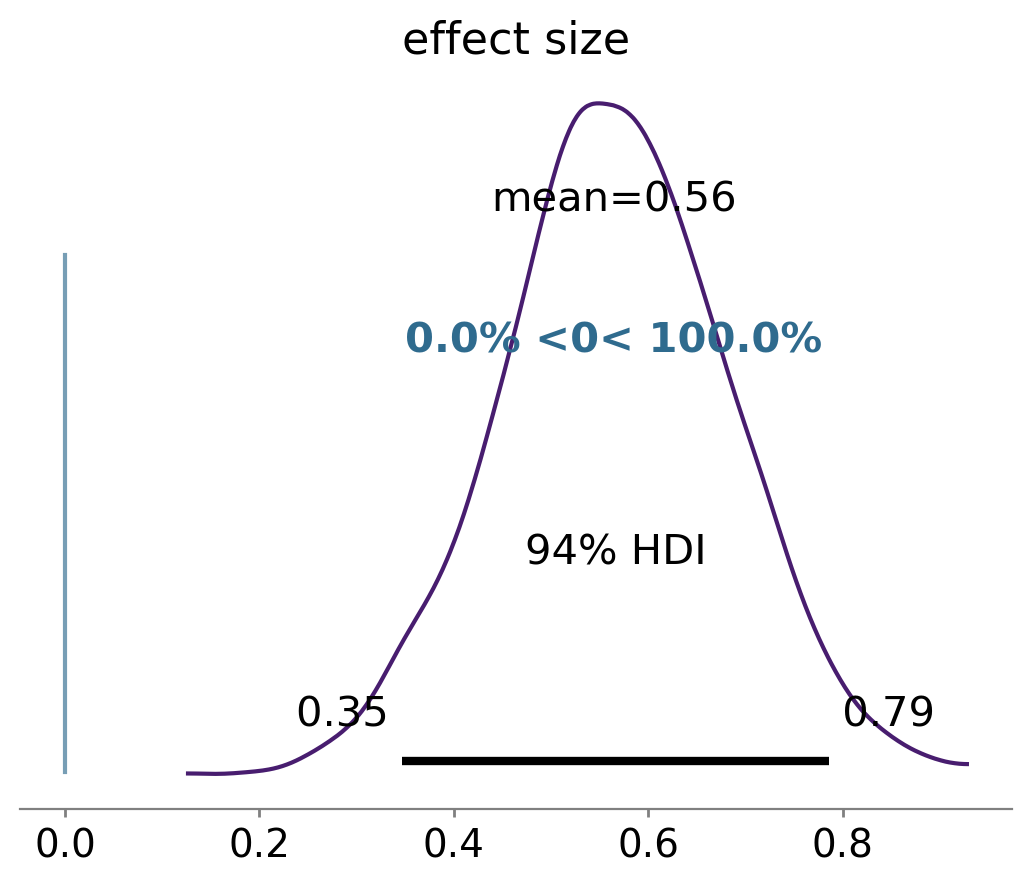

In [17]:
az.plot_posterior(trace, ref_val=0, var_names=["effect size"]);

In [18]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,77.98,2.02,74.04,81.73,0.05,0.04,1413.49,1608.82,1.0
beta,11.21,2.27,6.78,15.39,0.06,0.04,1425.90,1656.45,1.0
sigma,19.88,0.67,18.68,21.20,0.02,0.01,1864.13,1852.86,1.0
effect size,0.56,0.12,0.35,0.79,0.00,0.00,1412.43,1690.90,1.0


In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

scipy     : 1.10.1
pymc      : 5.6.1
numpy     : 1.25.2
seaborn   : 0.12.2
pandas    : 2.0.3
arviz     : 0.16.0
matplotlib: 3.7.2
bambi     : 0.12.0

Watermark: 2.4.3

